In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import sys
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from generate_data import *
from train_models import *
from honest_trees import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

This notebook is used to run the simulation experiments for fitting sparse sum of squares models with cts features. 

# Examine Generalisation performance for Sparse Linear Models 

In [24]:
## Look at dependence of generalisation with number of training samples 

In [25]:
def compute_theoretical_lower_bound(n,s,mu_k,qmin,beta,sigma):
    return s*mu_k*((beta**2)*qmin/12.0)**(s/(s+2))*(sigma**2/(4*n))**(1/(s+2))

In [26]:
n_train = [500,1000,1500,2000,2500]
n_test = 500
d = 100
beta = 1
sigma = 0.1
s = 20
n_avg = 20


In [27]:
# Initialize matrix for honest CART 
honest_CART_scores = []
honest_CART_error_bar = []

#Initialize matrix for honest CART with CCP 
honest_CART_CCP_scores = []
honest_CART_CCP_error_bar = []

#Initialize matrix for dishonest CART 
CART_scores = []
CART_error_bar = []

#Initialize Matrix for dishonest CART with CCP 
CART_CCP_scores = []
CART_CCP_error_bar = []

#Initialize Matrix for RF
RF_scores = []
RF_error_bar = []

#Initialize matrix for theoretical lower bound 


In [28]:
#This cell's code is used to fit and predict for on linear model varying across the number of training samples/sparsity 
for n in tqdm(n_train):
        honest_CART = []
        honest_CART_CCP = []
        CART = []
        CART_CCP = []
        RF = []
        for j in range(n_avg):
            #Create data to fit models 
            X_train = sample_uniform_X(n,d)
            X_honest = sample_uniform_X(n,d)
            X_test = sample_uniform_X(n_test,d)
            
            
            y_train = sum_of_squares(X_train,s,beta,sigma)
            y_honest = sum_of_squares(X_honest,s,beta,sigma)
            y_test = sum_of_squares(X_test,s,beta,0) #zero noise since we want to measure ||\hat{f} - f||_2
            
            
            
            #Fit and predict for all versions of CART
            honest_CART_MSE,honest_CART_CCP_MSE,CART_MSE,CART_CCP_MSE =  train_all_models(X_train,y_train,X_honest,y_honest,X_test,y_test,sigma,k = 5)
            honest_CART.append(honest_CART_MSE)
            honest_CART_CCP.append(honest_CART_CCP_MSE)
            CART.append(CART_MSE)
            CART_CCP.append(CART_CCP_MSE)
            
            #Fit and predict for RF
            rf = RandomForestRegressor(n_estimators = 100,max_features = 0.33)
            rf.fit(X_train,y_train)
            rf_preds = rf.predict(X_test)
            RF.append(mean_squared_error(y_test,rf_preds))
            
            
            
        #Store Performance in matrix
        honest_CART_scores.append(statistics.mean(honest_CART))
        honest_CART_error_bar.append(statistics.stdev(honest_CART))
        
        honest_CART_CCP_scores.append(statistics.mean(honest_CART_CCP))
        honest_CART_CCP_error_bar.append(statistics.stdev(honest_CART_CCP))
        
        CART_scores.append(statistics.mean(CART))
        CART_error_bar.append(statistics.stdev(CART))
        
        CART_CCP_scores.append(statistics.mean(CART_CCP))
        CART_CCP_error_bar.append(statistics.stdev(CART_CCP))
        
        RF_scores.append(statistics.mean(RF))
        RF_error_bar.append(statistics.stdev(RF))
     
 

100%|██████████| 5/5 [06:37<00:00, 79.57s/it] 


In [42]:
theoretical_lower_bound_matrix = []
mu_k = 0.8**s
for n in tqdm(n_train):
    theoretical_lower_bound_matrix.append(compute_theoretical_lower_bound(n,s,mu_k,1.0,0.4,sigma))


100%|██████████| 5/5 [00:00<00:00, 74898.29it/s]


# Plot Performance 

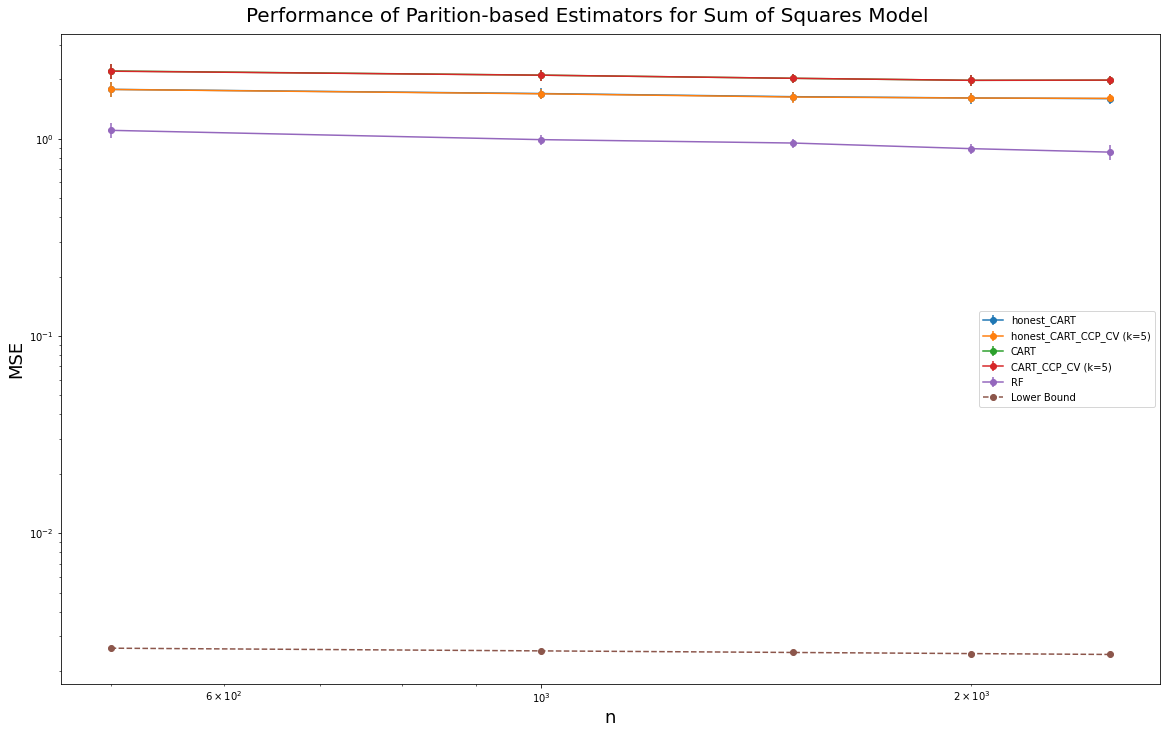

In [43]:
squares_lower_bound_fig,squares_lower_bound_axs = plt.subplots(1,1,figsize = (16,10),sharex = False,sharey = False)

#linear_lower_bound_axs.errorbar(n_train,RF_results_matrix,yerr = sd_RF_performance,marker = 'o',label = 'Random Forest')

#Plot Performance for different models 
squares_lower_bound_axs.errorbar(n_train,honest_CART_scores,yerr = honest_CART_error_bar,marker = 'o',label = 'honest_CART')
squares_lower_bound_axs.errorbar(n_train,honest_CART_CCP_scores,yerr = honest_CART_CCP_error_bar,marker = 'o',label = 'honest_CART_CCP_CV (k=5)')
squares_lower_bound_axs.errorbar(n_train,CART_scores,yerr = CART_error_bar,marker = 'o',label = 'CART')
squares_lower_bound_axs.errorbar(n_train,CART_CCP_scores,yerr = CART_CCP_error_bar,marker = 'o',label = 'CART_CCP_CV (k=5)')
squares_lower_bound_axs.errorbar(n_train,RF_scores,yerr = RF_error_bar,marker = 'o',label = 'RF' )


squares_lower_bound_axs.errorbar(n_train,theoretical_lower_bound_matrix,marker = 'o',label = 'Lower Bound',linestyle = 'dashed')


squares_lower_bound_axs.legend()
squares_lower_bound_axs.set_ylabel('MSE',fontsize = 18)
squares_lower_bound_axs.set_xlabel('n',fontsize = 18)
squares_lower_bound_fig.suptitle("Performance of Parition-based Estimators for Sum of Squares Model",fontsize = 20,y = 1.00)
plt.tight_layout(pad=0.4,w_pad=0.5, h_pad=1.0)
plt.yscale('log')
plt.xscale('log')

In [57]:
linear_lower_bound_fig.savefig('results/n_train_sparse_sum_of_squares_model_partition_cts')

# Look at dependence of generalisation performance for varying sparsity

In [60]:
n = 1500
n_test = 500
d = 100
beta = 1
sigma = 0.1
sparsity = [10,15,20,25,30]
n_avg = 20

In [61]:
# Initialize matrix for honest CART 
honest_CART_sparsity_scores = []
honest_CART_sparsity_error_bar = []

#Initialize matrix for honest CART with CCP 
honest_CART_CCP_sparsity_scores = []
honest_CART_CCP_sparsity_error_bar = []

#Initialize matrix for dishonest CART 
CART_sparsity_scores = []
CART_sparsity_error_bar = []

#Initialize Matrix for dishonest CART with CCP 
CART_CCP_sparsity_scores = []
CART_CCP_sparsity_error_bar = []

#Initialize Matrix for RF
RF_sparsity_scores = []
RF_sparsity_error_bar = []

#Initialize matrix for theoretical lower bound 
theoretical_sparsity_lower_bound_matrix = []

In [62]:
#This cell's code is used to fit and predict for on linear model varying across the number of training samples/sparsity 
for s in tqdm(sparsity):
        honest_CART = []
        honest_CART_CCP = []
        CART = []
        CART_CCP = []
        RF = []
        for j in range(n_avg):
            #Create data to fit models 
            X_train = sample_uniform_X(n,d)
            X_honest = sample_uniform_X(n,d)
            X_test = sample_uniform_X(n_test,d)
            
            
            y_train = linear_model(X_train,s,beta,sigma)
            y_honest = linear_model(X_honest,s,beta,sigma)
            y_test = linear_model(X_test,s,beta,0) #zero noise since we want to measure ||\hat{f} - f||_2
            
            
            
            #Fit and predict for all versions of CART
            honest_CART_MSE,honest_CART_CCP_MSE,CART_MSE,CART_CCP_MSE =  train_all_models(X_train,y_train,X_honest,y_honest,X_test,y_test,sigma,k = 5)
            honest_CART.append(honest_CART_MSE)
            honest_CART_CCP.append(honest_CART_CCP_MSE)
            CART.append(CART_MSE)
            CART_CCP.append(CART_CCP_MSE)
            
            #Fit and predict for RF
            rf = RandomForestRegressor(n_estimators = 100,max_features = 0.33)
            rf.fit(X_train,y_train)
            rf_preds = rf.predict(X_test)
            RF.append(mean_squared_error(y_test,rf_preds))
            
            
            
        #Store Performance in matrix
        honest_CART_sparsity_scores.append(statistics.mean(honest_CART))
        honest_CART_sparsity_error_bar.append(statistics.stdev(honest_CART))
        
        honest_CART_CCP_sparsity_scores.append(statistics.mean(honest_CART_CCP))
        honest_CART_CCP_sparsity_error_bar.append(statistics.stdev(honest_CART_CCP))
        
        CART_sparsity_scores.append(statistics.mean(CART))
        CART_sparsity_error_bar.append(statistics.stdev(CART))
        
        CART_CCP_sparsity_scores.append(statistics.mean(CART_CCP))
        CART_CCP_sparsity_error_bar.append(statistics.stdev(CART_CCP))
        
        RF_sparsity_scores.append(statistics.mean(RF))
        RF_sparsity_error_bar.append(statistics.stdev(RF))
        
        mu_k = 0.5**s
        theoretical_sparsity_lower_bound_matrix.append(compute_theoretical_lower_bound(n,s,mu_k,1.0,beta,sigma))
 

100%|██████████| 5/5 [05:50<00:00, 70.09s/it]


# Plot Performance 

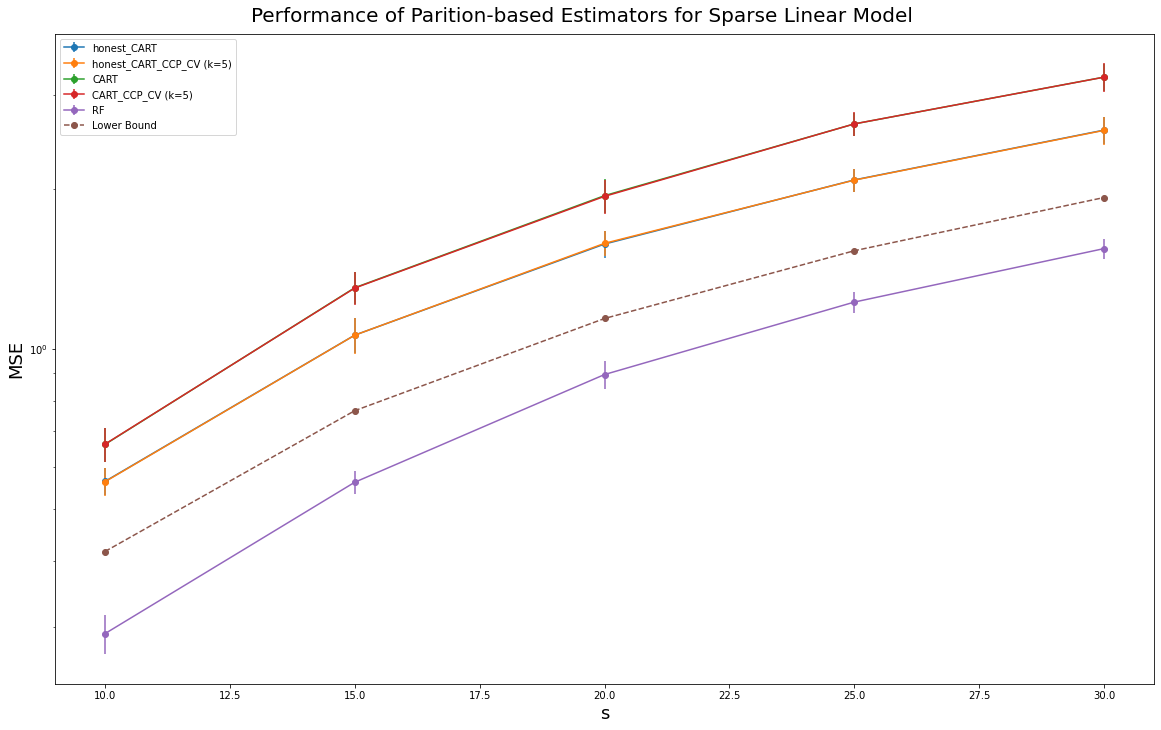

In [64]:
linear_lower_bound_sparsity_fig,linear_lower_bound_sparsity_axs = plt.subplots(1,1,figsize = (16,10),sharex = False,sharey = False)

#linear_lower_bound_axs.errorbar(n_train,RF_results_matrix,yerr = sd_RF_performance,marker = 'o',label = 'Random Forest')

#Plot Performance for different models 
linear_lower_bound_sparsity_axs.errorbar(sparsity,honest_CART_sparsity_scores,yerr = honest_CART_sparsity_error_bar,marker = 'o',label = 'honest_CART')
linear_lower_bound_sparsity_axs.errorbar(sparsity,honest_CART_CCP_sparsity_scores,yerr = honest_CART_CCP_sparsity_error_bar,marker = 'o',label = 'honest_CART_CCP_CV (k=5)')
linear_lower_bound_sparsity_axs.errorbar(sparsity,CART_sparsity_scores,yerr = CART_sparsity_error_bar,marker = 'o',label = 'CART')
linear_lower_bound_sparsity_axs.errorbar(sparsity,CART_CCP_sparsity_scores,yerr = CART_CCP_sparsity_error_bar,marker = 'o',label = 'CART_CCP_CV (k=5)')
linear_lower_bound_sparsity_axs.errorbar(sparsity,RF_sparsity_scores,yerr = RF_sparsity_error_bar,marker = 'o',label = 'RF' )


linear_lower_bound_sparsity_axs.errorbar(sparsity,theoretical_sparsity_lower_bound_matrix,marker = 'o',label = 'Lower Bound',linestyle = 'dashed')


linear_lower_bound_sparsity_axs.legend()
linear_lower_bound_sparsity_axs.set_ylabel('MSE',fontsize = 18)
linear_lower_bound_sparsity_axs.set_xlabel('s',fontsize = 18)
linear_lower_bound_sparsity_fig.suptitle("Performance of Parition-based Estimators for Sparse Linear Model",fontsize = 20,y = 1.00)
plt.tight_layout(pad=0.4,w_pad=0.5, h_pad=1.0)
plt.yscale('log')


In [65]:
linear_lower_bound_sparsity_fig.savefig('results/sparsity_sparse_sum_of_squares_model_partition_cts')